This is to test TTS models with benchmark sentences for speech synthesis.

Before running this script please DON'T FORGET: 
- to set file paths.
- to download related model files from TTS and WaveRNN.
- to checkout right commit versions (given next to the model) of TTS and WaveRNN.
- to set the right paths in the cell below.

Repositories:
- TTS: https://github.com/mozilla/TTS
- WaveRNN: https://github.com/erogol/WaveRNN

In [1]:
TTS_PATH = "/Users/thomas/workspace/ptf/faaake/TTS"

In [2]:
%load_ext autoreload
%autoreload 2
import os
import sys
import io
import torch 
import time
import numpy as np
from collections import OrderedDict
from matplotlib import pylab as plt

%pylab inline
rcParams["figure.figsize"] = (16,5)

# add libraries into environment
sys.path.append(TTS_PATH) # set this if TTS is not installed globally

import librosa
import librosa.display

from models.tacotron import Tacotron 
from layers import *
from utils.data import *
from utils.audio import AudioProcessor
from utils.generic_utils import load_config, setup_model
from utils.text import text_to_sequence
from utils.synthesis import synthesis, get_token_scores
from utils.visual import visualize

import IPython
from IPython.display import Audio

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns


Populating the interactive namespace from numpy and matplotlib


/Users/thomas/miniconda2/envs/mztts/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"
/Users/thomas/miniconda2/envs/mztts/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [3]:
def tts(model, text, CONFIG, use_cuda, ap, token_scores, speaker_id, language, use_gl, figures=True):
    t_1 = time.time()
    waveform, alignment, mel_spec, mel_postnet_spec, stop_tokens = synthesis(model, text, CONFIG, use_cuda, ap, token_scores, speaker_id, language, False, CONFIG.enable_eos_bos_chars)
    if not use_gl:
        waveform = wavernn.generate(torch.FloatTensor(mel_postnet_spec.T).unsqueeze(0).cuda(), batched=batched_wavernn, target=11000, overlap=550)

    print(" >  Run-time: {}".format(time.time() - t_1))
    if figures:                                                                                                         
        visualize(alignment, mel_postnet_spec, stop_tokens, text, ap.hop_length, CONFIG, mel_spec)                                                                       
    IPython.display.display(Audio(waveform, rate=CONFIG.audio['sample_rate']))  
    os.makedirs(OUT_FOLDER, exist_ok=True)
    file_name = text.replace(" ", "_").replace(".","") + ".wav"
    out_path = os.path.join(OUT_FOLDER, file_name)
    ap.save_wav(waveform, out_path)
    return alignment, mel_postnet_spec, stop_tokens, waveform

In [79]:
# Set constants
ROOT_PATH = '/Users/thomas/workspace/playground/gstmdms_new/laozi_german_long'
MODEL_PATH = ROOT_PATH + '/checkpoint_850000.pth.tar'
CONFIG_PATH = ROOT_PATH + '/config.json'
OUT_FOLDER = ROOT_PATH + '/out'
CONFIG = load_config(CONFIG_PATH)
# VOCODER_MODEL_PATH = "/media/erogol/data_ssd/Data/models/wavernn/ljspeech/mold_ljspeech_best_model/checkpoint_433000.pth.tar"
# VOCODER_CONFIG_PATH = "/media/erogol/data_ssd/Data/models/wavernn/ljspeech/mold_ljspeech_best_model/config.json"
# VOCODER_CONFIG = load_config(VOCODER_CONFIG_PATH)
use_cuda = False
CONFIG.windowing = True
use_gl = True    # use GL if True
batched_wavernn = False    # use batched wavernn inference if True

In [80]:
# LOAD TTS MODEL
from utils.text.symbols import symbols, phonemes

# load the model
# num_chars = len(phonemes) if CONFIG.use_phonemes else len(symbols)
model = setup_model(CONFIG)

# load the audio processor
ap = AudioProcessor(**CONFIG.audio)         


# load model state
if use_cuda:
    cp = torch.load(MODEL_PATH)
else:
    cp = torch.load(MODEL_PATH, map_location=lambda storage, loc: storage)

# load the model
model.load_state_dict(cp['model'])
if use_cuda:
    model.cuda()
model.eval()
print(cp['step'])

 > Using model: Tacotron
 > Setting up Audio Processor...
 | > bits:None
 | > sample_rate:16000
 | > num_mels:80
 | > min_level_db:-100
 | > frame_shift_ms:12.5
 | > frame_length_ms:50
 | > ref_level_db:20
 | > num_freq:1025
 | > power:1.5
 | > preemphasis:0.98
 | > griffin_lim_iters:60
 | > signal_norm:True
 | > symmetric_norm:False
 | > mel_fmin:50.0
 | > mel_fmax:7600.0
 | > max_norm:1.0
 | > clip_norm:True
 | > do_trim_silence:False
 | > n_fft:2048
 | > hop_length:200
 | > win_length:800
850000


In [81]:
style_tokens = model.global_style_tokens.style_token_layer.style_tokens.detach().numpy()

Explained variation per principal component: [0.14753759 0.13988073]


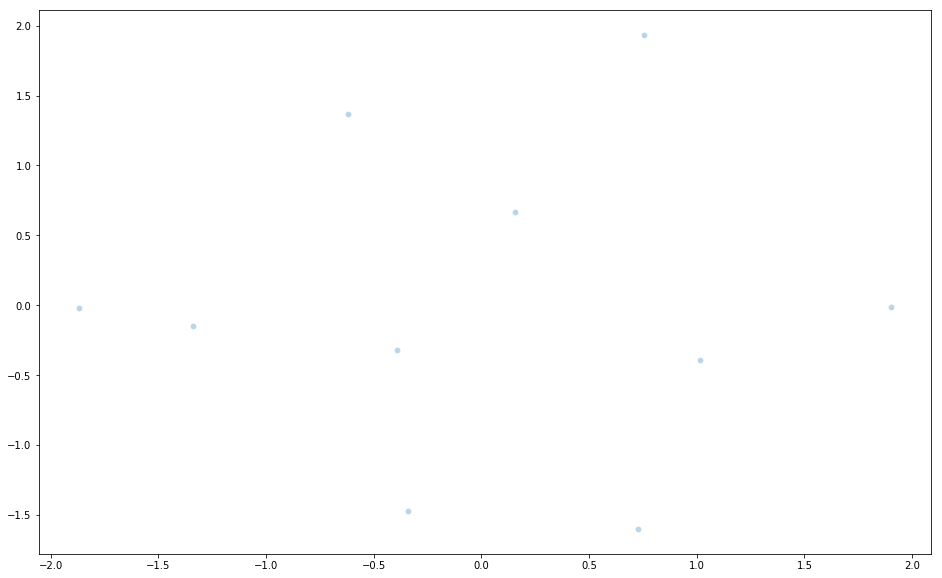

In [82]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(style_tokens)
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=pca_result[:,0],
    y=pca_result[:,1],
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.3
)

[t-SNE] Computing 9 nearest neighbors...
[t-SNE] Indexed 10 samples in 0.000s...
[t-SNE] Computed neighbors for 10 samples in 0.009s...
[t-SNE] Computed conditional probabilities for sample 10 / 10
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 46.857235
[t-SNE] KL divergence after 300 iterations: 0.256610


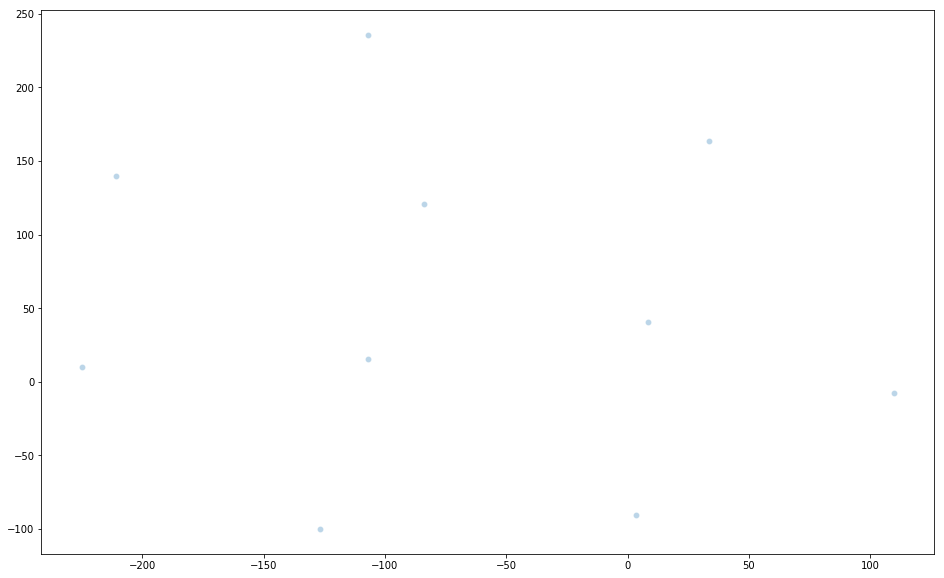

In [83]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(style_tokens)
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=tsne_results[:,0],
    y=tsne_results[:,1],
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.3
)

Explained variation per principal component: [0.32789797 0.27791893]


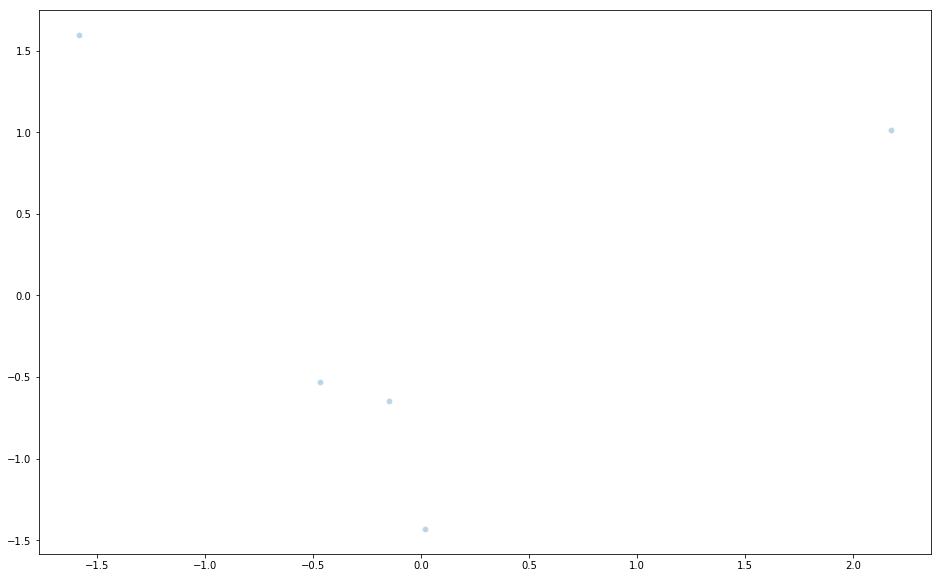

In [84]:
speaker_embeddings = model.speaker_embeddings.weight.detach().numpy()
pca = PCA(n_components=2)
pca_result = pca.fit_transform(speaker_embeddings)
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=pca_result[:,0],
    y=pca_result[:,1],
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.3
)

In [10]:
# LOAD WAVERNN
if use_gl == False:
    from WaveRNN.models.wavernn import Model
    bits = 10

    wavernn = Model(
            rnn_dims=512,
            fc_dims=512,
            mode="mold",
            pad=2,
            upsample_factors=VOCODER_CONFIG.upsample_factors,  # set this depending on dataset
            feat_dims=VOCODER_CONFIG.audio["num_mels"],
            compute_dims=128,
            res_out_dims=128,
            res_blocks=10,
            hop_length=ap.hop_length,
            sample_rate=ap.sample_rate,
        ).cuda()


    check = torch.load(VOCODER_MODEL_PATH)
    wavernn.load_state_dict(check['model'])
    if use_cuda:
        wavernn.cuda()
    wavernn.eval();

In [102]:

# f = "/Users/thomas/workspace/data/cv-de/clips/121dc01648fc3a99b9681a279a1aa2b2d5d58d88652937fa52f3aac7202dd1d74863154b277adc1c6af55f1797afb93196b16aff11605645122b9357c5a7b200.wav"
# f = "/Users/thomas/workspace/playground/Kanzlerin_41_16_f000041.wav"
f1 = "/Users/thomas/workspace/data/LJSpeech-1.1/wavs/LJ020-0028.wav"
f_positive = "/Users/thomas/workspace/data/LJSpeech-1.1/wavs/LJ020-0107.wav"
f_nice = "/Users/thomas/workspace/data/de_DE/by_book/male/karlsson/odysseus/wavs/odysseus_18_f000128.wav"

In [64]:
def get_scores(f):
    return get_token_scores(model, f, ap, use_cuda).squeeze().detach().numpy() 
score = get_scores(f)

/Users/thomas/miniconda2/envs/mztts/lib/python3.6/site-packages/scipy/signal/signaltools.py:1363: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]


In [88]:
print(score)
print(score.shape)
style_tokens.dot(style_tokens.T)

[-0.6208855   0.16306804  0.01404881 -0.7323382  -0.18640284  0.63815725
  0.7259098  -0.08396999 -0.15383038 -0.480612  ]
(10,)


array([[ 7.9818535 , -1.0055346 , -0.29185462, -0.77444106,  0.2571088 ,
         0.04206303, -0.72044784, -1.2536302 ,  0.1818788 , -0.333219  ],
       [-1.0055346 ,  9.067631  ,  0.44987383, -0.8027496 ,  0.1328965 ,
        -0.1491745 ,  1.2909812 ,  0.12733722,  1.4276935 ,  0.6374935 ],
       [-0.29185462,  0.44987383,  9.814461  ,  1.2220752 , -0.30054232,
         0.08705802, -0.0176098 ,  1.044781  ,  0.8010408 , -0.39726278],
       [-0.77444106, -0.8027496 ,  1.2220752 ,  8.27397   ,  0.24927329,
         0.3587777 , -0.68663913, -0.7496944 , -0.19673124,  1.2499497 ],
       [ 0.2571088 ,  0.1328965 , -0.30054232,  0.24927329,  8.920225  ,
        -0.5773971 ,  1.0824835 ,  0.22620565,  0.6037746 ,  0.8351842 ],
       [ 0.04206303, -0.1491745 ,  0.08705802,  0.3587777 , -0.5773971 ,
         8.120535  ,  0.77507037, -1.4277291 , -1.1158195 ,  0.07580206],
       [-0.72044784,  1.2909812 , -0.0176098 , -0.68663913,  1.0824835 ,
         0.77507037,  9.227466  ,  0.16814497

### Comparision with https://mycroft.ai/blog/available-voices/

In [89]:
model.eval()
model.decoder.max_decoder_steps = 2000

model.decoder.attention_rnn.windowing=True

CONFIG.text_cleaner = "phoneme_cleaners"
CONFIG.phoneme_language = "de"

In [113]:

# sentence = "Seine Fuerenden Berater hatten Donald Tramp seit Wochen beschworen berichteten US-Medien, Lassen Sie das mit den Zoellen bleiben!"
sentence = "Ohne Oel wird das ganze nichts, stoehnte der Admiral, der seit langem auf Nachschub wartete, und ungeduldig wurde."
# sentence = "Eine ähnliche Situation, das heißt ähnlich schlechte Situation, kam für den alten Fritz auf."
sentence = "Angela Merkel ist als Klimakanzlerin gestartet. Dann vernachlässigte sie das Thema. Nun, kurz vor dem Ende, will sie damit noch einmal neu anfangen."


151

/Users/thomas/miniconda2/envs/mztts/lib/python3.6/site-packages/scipy/signal/signaltools.py:1363: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]


[-0.6450071   0.12420929 -0.03502836 -0.60061044 -0.05473641  0.5580506
  0.6575459  -0.08183959 -0.11113058 -0.41358328]


/Users/thomas/miniconda2/envs/mztts/lib/python3.6/site-packages/librosa/util/utils.py:1725: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(x.dtype, float) or np.issubdtype(x.dtype, complex):


 >  Run-time: 7.355752944946289
anɡəlɑː mɛɾkəl ɪst als kliːmakantslərɪn ɡəʃtaɾtət. dan fɛɾnaxlasɪçtə ziː das teːmɑː. nuːn, kʊɐts fɔɾ deːm ɛndə, vɪl ziː dɑːmɪt nɔx aɪnmɑːl nɔø anfaŋən.


/Users/thomas/miniconda2/envs/mztts/lib/python3.6/site-packages/librosa/display.py:656: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(data.dtype, np.complex):


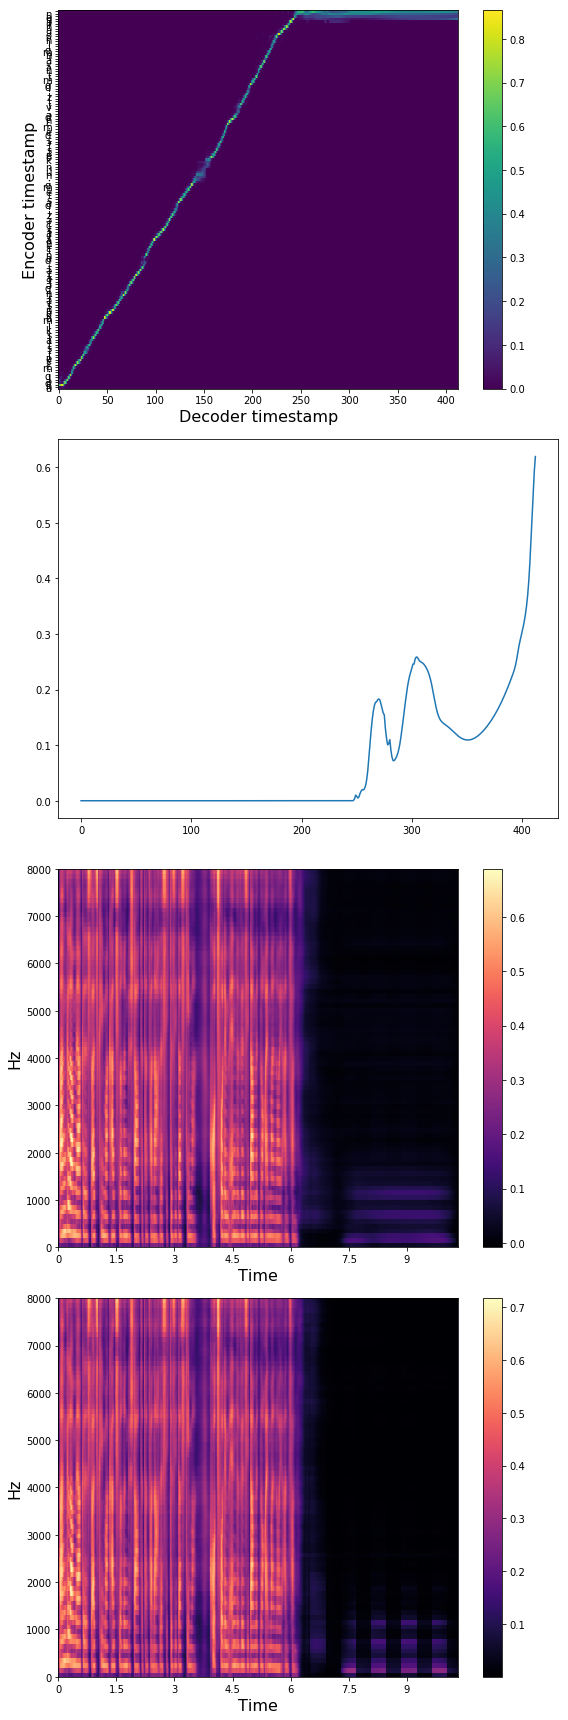

In [112]:
token_scores=get_scores(f1)
print(token_scores)
align, spec, stop_tokens, wav = tts(model, sentence, CONFIG, use_cuda, ap, token_scores, 0, "de", use_gl=use_gl, figures=True)

/Users/thomas/miniconda2/envs/mztts/lib/python3.6/site-packages/scipy/signal/signaltools.py:1363: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]


[-0.3565743   0.48343477  0.51551634 -0.310386   -0.5277979   0.616086
  0.5563002   0.03097672 -0.3096727  -0.4567299 ]


/Users/thomas/miniconda2/envs/mztts/lib/python3.6/site-packages/librosa/util/utils.py:1725: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(x.dtype, float) or np.issubdtype(x.dtype, complex):


 >  Run-time: 5.1852381229400635
zaɪnə fuːrəndən bərɑːtɜ hatən doːnalt tɾʊmp zaɪt vɔxən bəʃvoːrən bərɪçtətən uːɛsmeːdɪən, lasən ziː das mɪt deːn tsœlən blaɪbən!


/Users/thomas/miniconda2/envs/mztts/lib/python3.6/site-packages/librosa/display.py:656: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(data.dtype, np.complex):


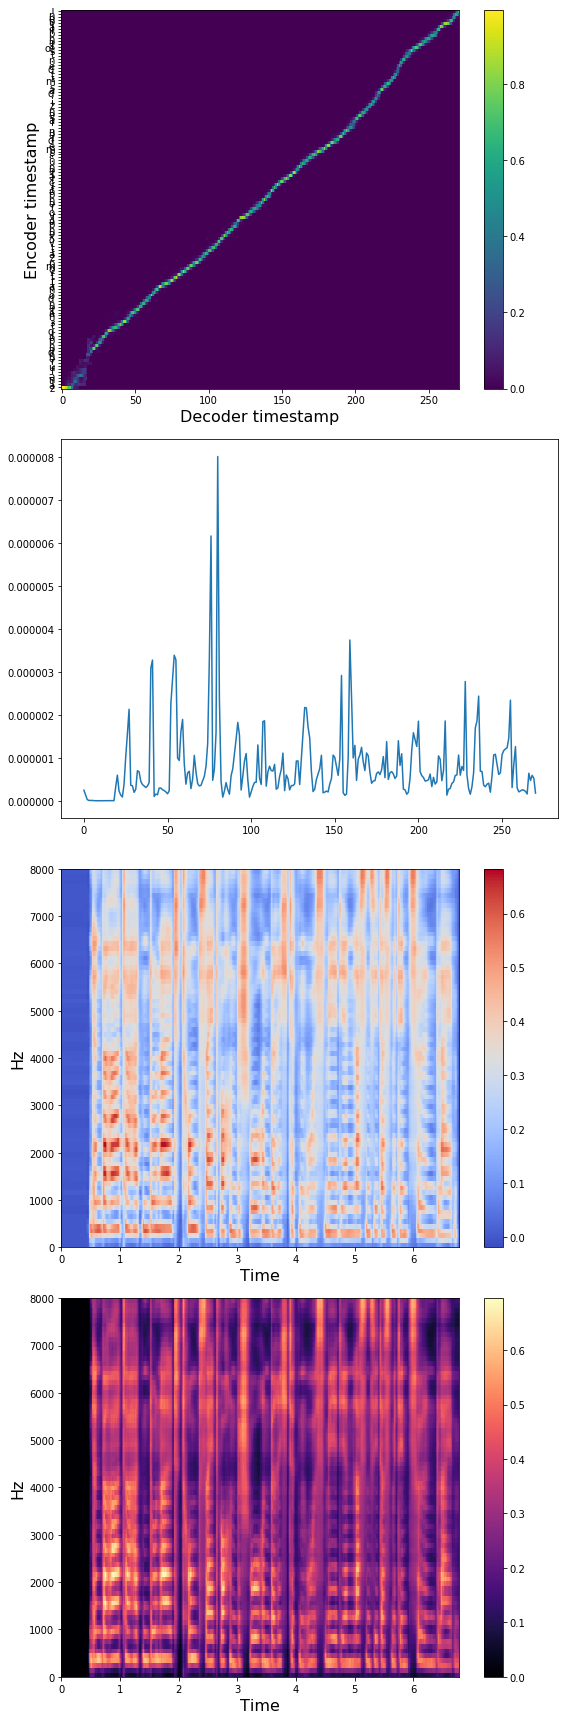

In [78]:
token_scores=get_scores(f_positive)
print(token_scores)
align, spec, stop_tokens, wav = tts(model, sentence, CONFIG, use_cuda, ap, token_scores, 1, "de", use_gl=use_gl, figures=True)

In [68]:
token_scores = np.copy(score)
token_scores = np.roll(token_scores, 0)
align, spec, stop_tokens, wav = tts(model, sentence, CONFIG, use_cuda, ap, token_scores, 4, "de", use_gl=use_gl, figures=True)

   | > Decoder stopped with 'max_decoder_steps


/Users/thomas/miniconda2/envs/mztts/lib/python3.6/site-packages/librosa/util/utils.py:1725: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(x.dtype, float) or np.issubdtype(x.dtype, complex):


KeyboardInterrupt: 

/Users/thomas/miniconda2/envs/mztts/lib/python3.6/site-packages/librosa/util/utils.py:1725: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(x.dtype, float) or np.issubdtype(x.dtype, complex):


 >  Run-time: 2.4064509868621826
aʊf deːn ziːbən rɔbənklɪpən, zɪtsən ziːbən rɔbɛnzɪpən


/Users/thomas/miniconda2/envs/mztts/lib/python3.6/site-packages/librosa/display.py:656: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(data.dtype, np.complex):


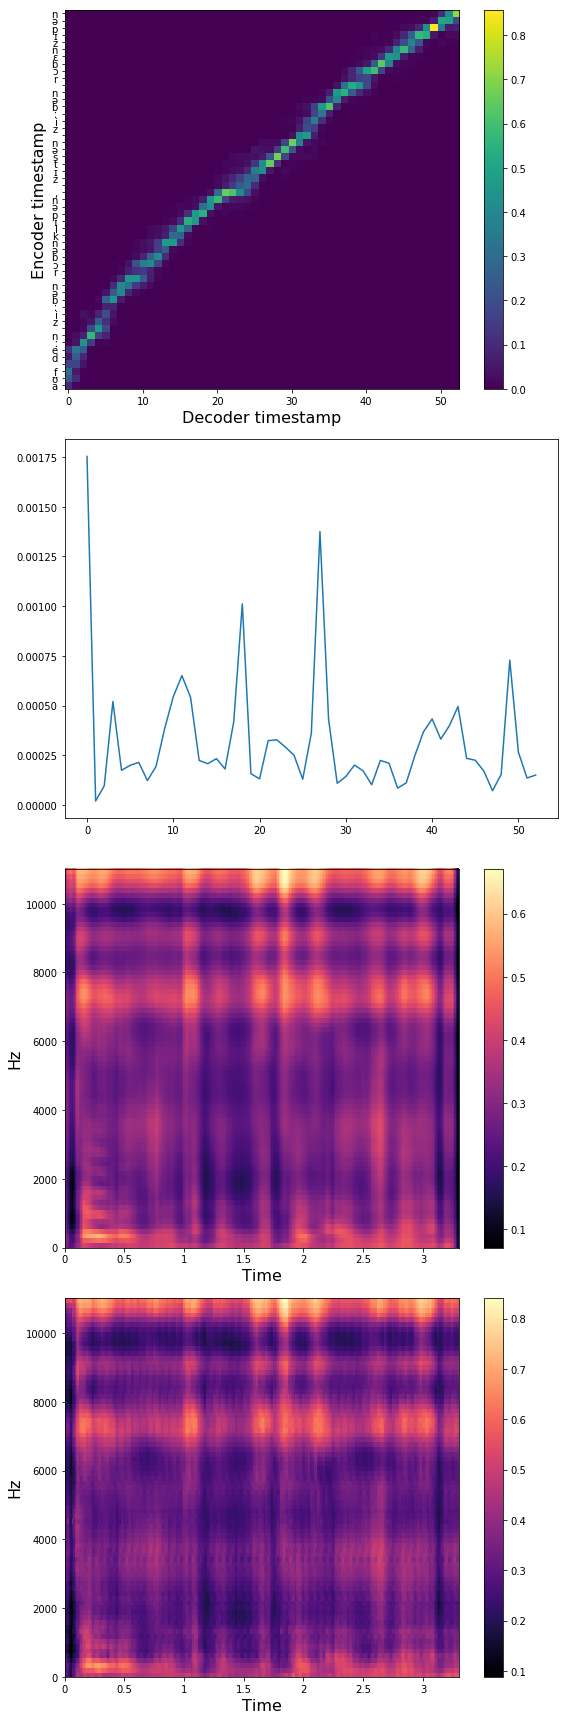

In [90]:
token_scores = np.copy(score)
token_scores[2] = 0.5
align, spec, stop_tokens, wav = tts(model, sentence, CONFIG, use_cuda, ap, token_scores, use_gl=use_gl, figures=True)

/Users/thomas/miniconda2/envs/mztts/lib/python3.6/site-packages/librosa/util/utils.py:1725: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(x.dtype, float) or np.issubdtype(x.dtype, complex):


 >  Run-time: 2.248182773590088
aʊf deːn ziːbən rɔbənklɪpən, zɪtsən ziːbən rɔbɛnzɪpən


/Users/thomas/miniconda2/envs/mztts/lib/python3.6/site-packages/librosa/display.py:656: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(data.dtype, np.complex):


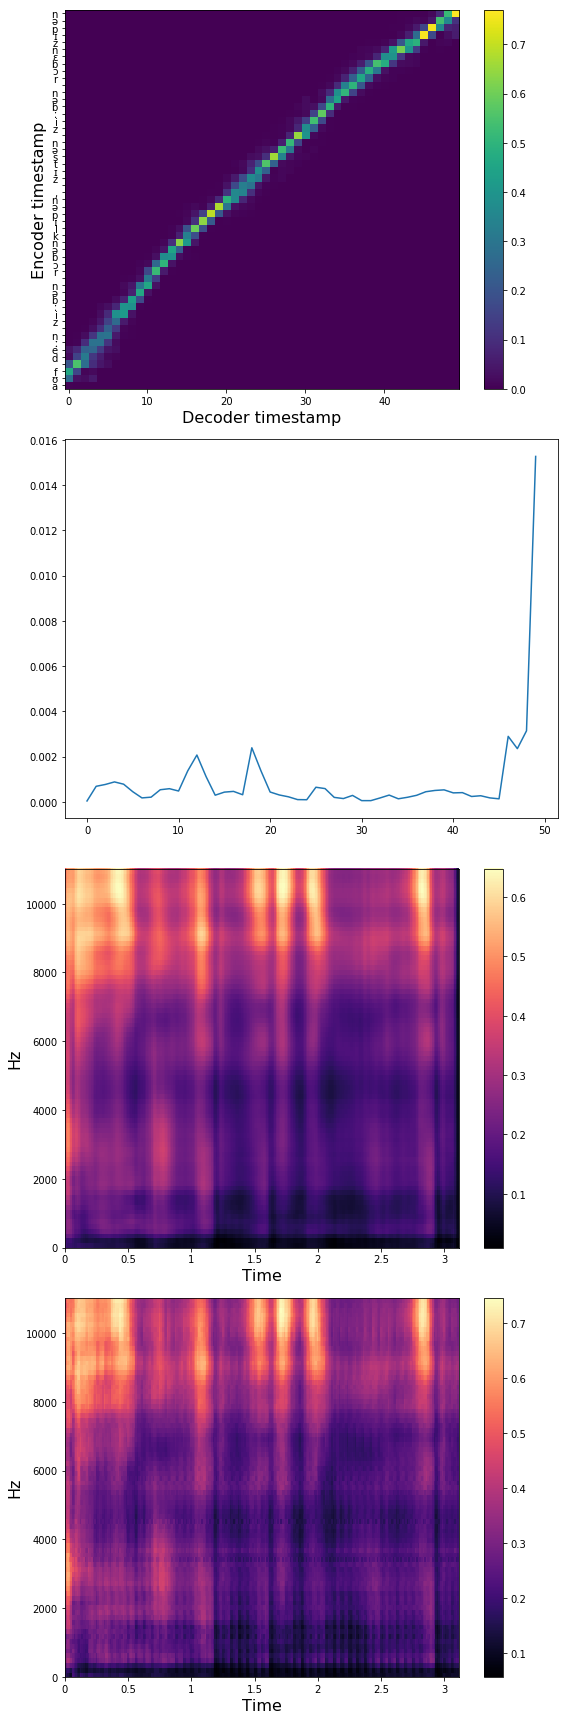

In [91]:
token_scores = np.copy(score)
token_scores[3] = 0.5
align, spec, stop_tokens, wav = tts(model, sentence, CONFIG, use_cuda, ap, token_scores, use_gl=use_gl, figures=True)

In [92]:
score

array([-0.04465364,  0.04064929, -0.16334413,  0.01838532, -0.07181823,
       -0.2778581 , -0.07349181,  0.14976259,  0.03571774, -0.21767282,
        0.31751707, -0.04350594,  0.1791306 , -0.05210488, -0.25057942,
       -0.0483922 ], dtype=float32)

/Users/thomas/miniconda2/envs/mztts/lib/python3.6/site-packages/librosa/util/utils.py:1725: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(x.dtype, float) or np.issubdtype(x.dtype, complex):


 >  Run-time: 1.8064448833465576
aʊf deːn ziːbən rɔbənklɪpən, zɪtsən ziːbən rɔbɛnzɪpən


/Users/thomas/miniconda2/envs/mztts/lib/python3.6/site-packages/librosa/display.py:656: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(data.dtype, np.complex):


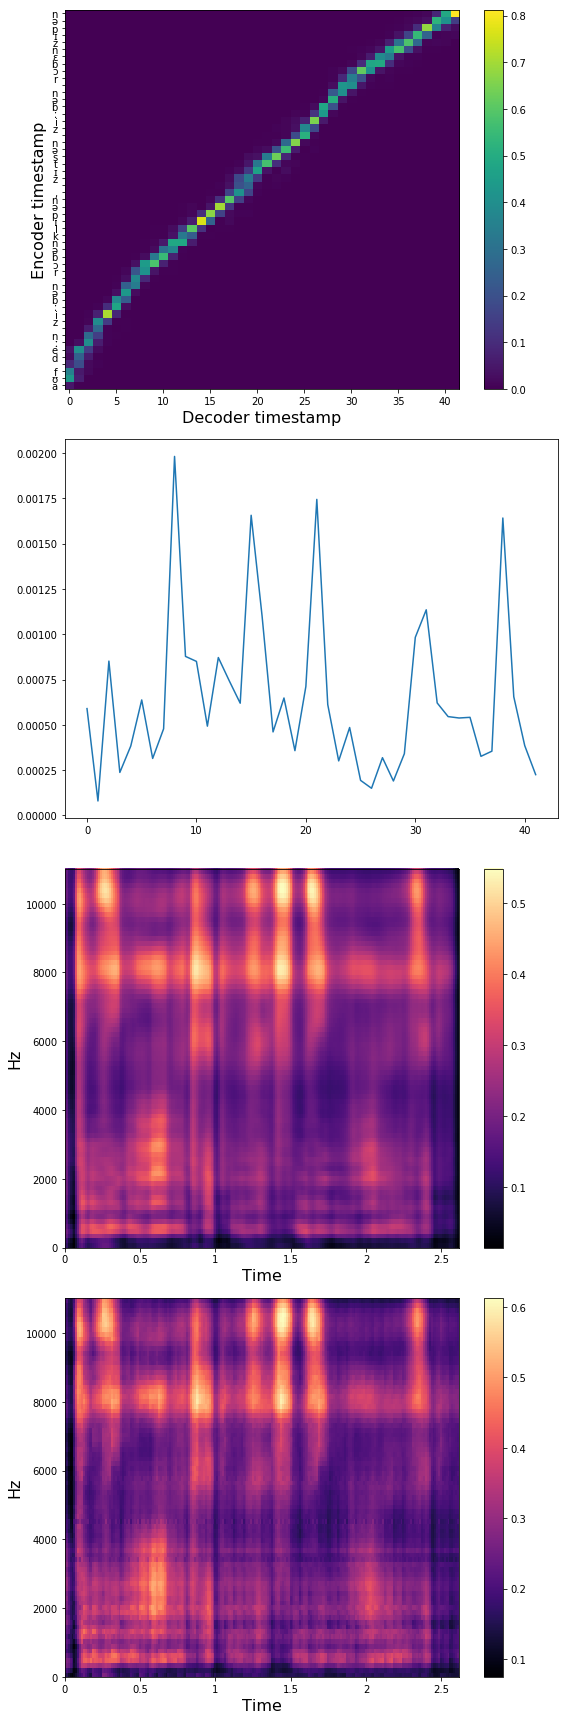

In [80]:
token_scores = score
token_scores[4] *= 2
align, spec, stop_tokens, wav = tts(model, sentence, CONFIG, use_cuda, ap, token_scores, use_gl=use_gl, figures=True)

In [ ]:
align, spec, stop_tokens, wav = tts(model, sentence, CONFIG, use_cuda, ap, use_gl=use_gl, figures=True)

In [ ]:
align, spec, stop_tokens, wav = tts(model, sentence, CONFIG, use_cuda, ap, use_gl=use_gl, figures=True)

In [ ]:
align, spec, stop_tokens, wav = tts(model, sentence, CONFIG, use_cuda, ap, use_gl=use_gl, figures=True)

### Comparison with https://keithito.github.io/audio-samples/

In [ ]:
sentence = "Generative adversarial network or variational auto-encoder."
align, spec, stop_tokens, wav = tts(model, sentence, CONFIG, use_cuda, ap, use_gl=use_gl, figures=True)

In [ ]:
sentence = "Scientists at the CERN laboratory say they have discovered a new particle."
align, spec, stop_tokens, wav = tts(model, sentence, CONFIG, use_cuda, ap, use_gl=use_gl, figures=True)

In [ ]:
sentence = "Here’s a way to measure the acute emotional intelligence that has never gone out of style."
align, spec, stop_tokens, wav = tts(model, sentence, CONFIG, use_cuda, ap, use_gl=use_gl, figures=True)

In [ ]:
sentence = "President Trump met with other leaders at the Group of 20 conference."
align, spec, stop_tokens, wav = tts(model, sentence, CONFIG, use_cuda, ap, use_gl=use_gl, figures=True)

In [ ]:
sentence = "The buses aren't the problem, they actually provide a solution."
align, spec, stop_tokens, wav = tts(model, sentence, CONFIG, use_cuda, ap, use_gl=use_gl, figures=True)

### Comparison with https://google.github.io/tacotron/publications/tacotron/index.html

In [ ]:
sentence = "Generative adversarial network or variational auto-encoder."
align, spec, stop_tokens, wav = tts(model, sentence, CONFIG, use_cuda, ap, use_gl=use_gl, figures=True)

In [ ]:
sentence = "Basilar membrane and otolaryngology are not auto-correlations."
align, spec, stop_tokens, wav = tts(model, sentence, CONFIG, use_cuda, ap, use_gl=use_gl, figures=True)

In [ ]:
sentence = " He has read the whole thing."
align, spec, stop_tokens, wav = tts(model, sentence, CONFIG, use_cuda, ap, use_gl=use_gl, figures=True)

In [ ]:
sentence = "He reads books."
align, spec, stop_tokens, wav = tts(model, sentence, CONFIG, use_cuda, ap, use_gl=use_gl, figures=True)

In [ ]:
sentence = "Thisss isrealy awhsome."
align, spec, stop_tokens, wav = tts(model, sentence, CONFIG, use_cuda, ap, use_gl=use_gl, figures=True)

In [ ]:
sentence = "This is your internet browser, Firefox."
align, spec, stop_tokens, wav = tts(model, sentence, CONFIG, use_cuda, ap, use_gl=use_gl, figures=True)

In [ ]:
sentence = "This is your internet browser Firefox."
align, spec, stop_tokens, wav = tts(model, sentence, CONFIG, use_cuda, ap, use_gl=use_gl, figures=True)

In [ ]:
sentence = "The quick brown fox jumps over the lazy dog."
align, spec, stop_tokens, wav = tts(model, sentence, CONFIG, use_cuda, ap, use_gl=use_gl, figures=True)

In [ ]:
sentence = "Does the quick brown fox jump over the lazy dog?"
align, spec, stop_tokens, wav = tts(model, sentence, CONFIG, use_cuda, ap, use_gl=use_gl, figures=True)

In [ ]:
sentence = "Eren, how are you?"
align, spec, stop_tokens, wav = tts(model, sentence, CONFIG, use_cuda, ap, use_gl=use_gl, figures=True)

### Hard Sentences

In [ ]:
sentence = "Encouraged, he started with a minute a day."
align, spec, stop_tokens, wav = tts(model, sentence, CONFIG, use_cuda, ap, use_gl=use_gl, figures=True)

In [ ]:
sentence = "His meditation consisted of “body scanning” which involved focusing his mind and energy on each section of the body from head to toe ."
align, spec, stop_tokens, wav = tts(model, sentence, CONFIG, use_cuda, ap, use_gl=use_gl, figures=True)

In [ ]:
sentence = "Recent research at Harvard has shown meditating for as little as 8 weeks can actually increase the grey matter in the parts of the brain responsible for emotional regulation and learning . "
align, spec, stop_tokens, wav = tts(model, sentence, CONFIG, use_cuda, ap, use_gl=use_gl, figures=True)

In [ ]:
sentence = "If he decided to watch TV he really watched it."
align, spec, stop_tokens, wav = tts(model, sentence, CONFIG, use_cuda, ap, use_gl=use_gl, figures=True)

In [ ]:
sentence = "Often we try to bring about change through sheer effort and we put all of our energy into a new initiative ."
align, spec, stop_tokens, wav = tts(model, sentence, CONFIG, use_cuda, ap, use_gl=use_gl, figures=True)

In [ ]:
# for twb dataset
sentence = "In our preparation for Easter, God in his providence offers us each year the season of Lent as a “sacramental sign of our conversion."
align, spec, stop_tokens, wav = tts(model, sentence, CONFIG, use_cuda, ap, use_gl=use_gl, figures=True)

In [ ]:
# !zip benchmark_samples/samples.zip benchmark_samples/*